In [1]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [1]:
from audio_processing import processing
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from python_speech_features import mfcc
from pydub import AudioSegment

## Resampling
Resampling to 22050Hz frequency

In [2]:
processing.resample_dir('./mp3', './resampled', sr=22050, channels=1)

Progress: 100%|████████████████████████████████████████████████████████████████████| 2150/2150 [54:08<00:00,  1.51s/it]


'2150 files from ./mp3 resampled into ./resampled'

## Signal/noise split

In [3]:
processing.split_signal_noise_dir('./resampled', './resampled')

Progress: 100%|██████████████████████████████████████████████████████████████████| 2150/2150 [2:57:43<00:00,  4.96s/it]


'2150 files from ./resampled signal/noise split into ./resampled'

## Class evaluation

In [2]:
data = pd.read_csv(r'metadata.csv')
data['Name'] = data.Genus +' '+ data.Specific_epithet
data.Path = data.Path.apply(lambda x: x[5:])
data['class_label'] = pd.factorize(data.Name)[0]

In [3]:
data.Name.value_counts()

Chloris chloris               43
Erithacus rubecula            43
Glaucidium passerinum         43
Acrocephalus dumetorum        43
Acrocephalus schoenobaenus    43
Crex crex                     43
Hippolais icterina            43
Sylvia communis               43
Aegolius funereus             43
Luscinia megarhynchos         43
Sylvia curruca                43
Athene noctua                 43
Emberiza calandra             43
Locustella naevia             43
Phylloscopus trochilus        43
Troglodytes troglodytes       43
Pyrrhula pyrrhula             43
Acrocephalus palustris        43
Emberiza hortulana            43
Cuculus canorus               43
Sylvia borin                  43
Sonus naturalis               43
Parus major                   43
Turdus philomelos             43
Acrocephalus arundinaceus     43
Sylvia atricapilla            43
Carduelis carduelis           43
Turdus merula                 43
Strix aluco                   43
Hirundo rustica               43
Bubo bubo 

## Train, validate, test

In [4]:
train, validation, test = processing.tvt_split(data, 'Name')
data.loc[train, 'model_group'] = 'train'
data.loc[validation, 'model_group'] = 'validation'
data.loc[test, 'model_group'] = 'test'

## Extracting features

In [ ]:
train_files = data.loc[train].Path.to_list()
train_class = data.loc[train].class_label.to_list()

X_train, y_train = processing.feature_extraction(train_files, train_class, r'./samples/signal/')

  2%|█▍                                                                              | 26/1500 [00:12<12:16,  2.00it/s]

In [ ]:
valid_files = data.loc[validation].Path.to_list()
valid_class = data.loc[validation].class_label.to_list()

X_valid, y_valid = processing.feature_extraction(valid_files, valid_class, r'./samples/signal/')

In [ ]:
test_files = data.loc[test].Path.to_list()
test_class = data.loc[test].class_label.to_list()

X_test, y_test = processing.feature_extraction(test_files, test_class, r'./samples/signal/')

In [25]:
np.save('./numpy_data/X_train.npy', X_train, allow_pickle=True, fix_imports=False)
np.save('./numpy_data/y_train.npy', y_train, allow_pickle=True, fix_imports=False)
np.save('./numpy_data/X_valid.npy', X_valid, allow_pickle=True, fix_imports=False)
np.save('./numpy_data/y_valid.npy', y_valid, allow_pickle=True, fix_imports=False)
np.save('./numpy_data/X_test.npy', X_test, allow_pickle=True, fix_imports=False)
np.save('./numpy_data/y_test.npy', y_test, allow_pickle=True, fix_imports=False)

In [28]:
# from scipy.signal.windows import hann
song = AudioSegment.from_mp3(r'./samples/signal/Sonus-naturalis-336380.mp3')
samples = song.get_array_of_samples()
samples = np.array(samples, dtype=float)

In [29]:
sr = 22050

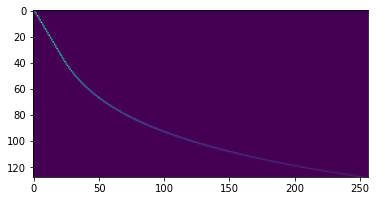

In [317]:
filter_banks = librosa.filters.mel(sr=sr, n_fft=512, n_mels=128)
filter_banks.shape
plt.imshow(filter_banks)
plt.show()

In [285]:
mel_spec = librosa.feature.melspectrogram(samples[:3*sr], sr=sr, n_fft=512, hop_length=512, n_mels=128)
mel_spec.shape

(128, 130)

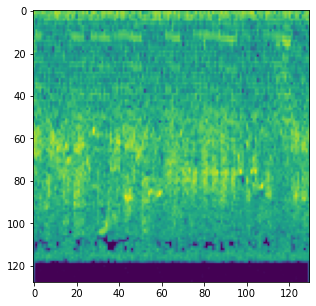

In [279]:
log_mel_spec = librosa.power_to_db(mel_spec)
plt.figure(figsize=(10,5))
plt.imshow(log_mel_spec)
plt.show()

In [244]:
len(samples)/22050

180.90689342403627

In [69]:
mfccs = librosa.feature.mfcc(samples[:3*sr], n_mfcc=13, sr=sr, hop_length=int(512*.75), n_mels=128, n_fft=512)
mfccs.shape

(13, 173)

In [66]:
mfccs.shape[1]//130

1

In [67]:
import librosa.display

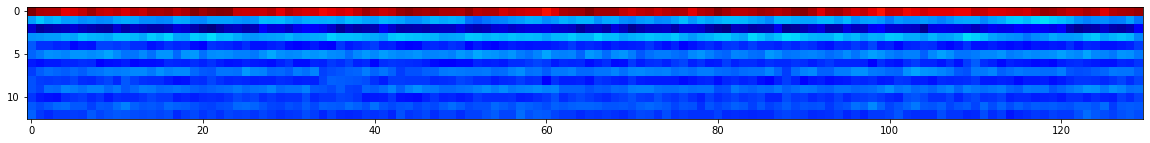

In [68]:
plt.figure(figsize=(20,10))
# librosa.display.specshow(mfccs,
#                         x_axis='time',
#                         sr=sr)
# plt.colorbar(format="%+2f")
plt.imshow(mfccs, cmap='jet')
plt.show()

In [73]:
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

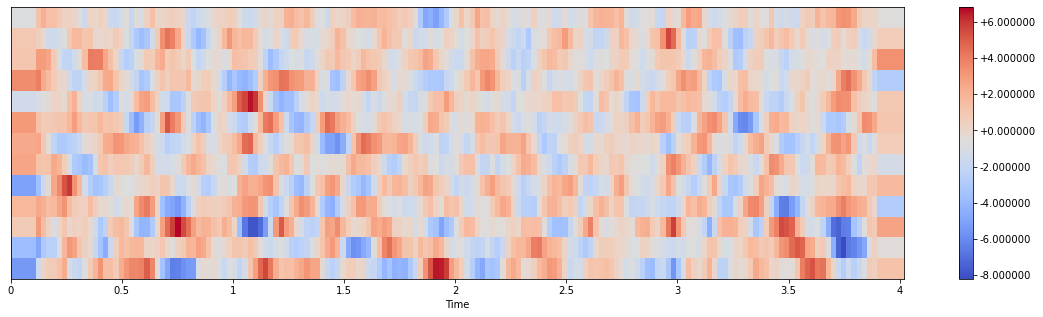

In [74]:
plt.figure(figsize=(20,5))
librosa.display.specshow(delta_mfccs,
                        x_axis='time',
                        sr=sr)
plt.colorbar(format="%+2f")
# plt.imshow(mfccs)
plt.show()

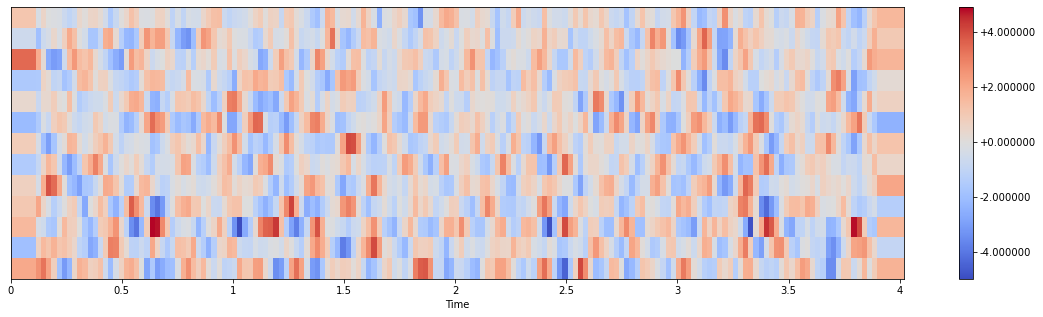

In [75]:
plt.figure(figsize=(20,5))
librosa.display.specshow(delta2_mfccs,
                        x_axis='time',
                        sr=sr)
plt.colorbar(format="%+2f")
# plt.imshow(mfccs)
plt.show()

In [76]:
comprehensive_mfccs = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
comprehensive_mfccs.shape

(39, 173)

In [77]:
comprehensive_mfccs[:,:1000].shape

(39, 173)

In [78]:
comprehensive_mfccs

array([[ 540.29207021,  510.8232439 ,  507.21760832, ...,  507.94511748,
         512.10044252,  522.54009056],
       [  59.75714494,   85.9317849 ,   76.42974936, ...,   55.93171764,
          50.44196978,   31.72508103],
       [ -80.27981536, -115.79016713, -102.95254979, ..., -100.19465062,
         -99.13228666,  -57.84011558],
       ...,
       [   3.48769929,    3.48769929,    3.48769929, ...,    1.66937953,
           1.66937953,    1.66937953],
       [  -0.58342805,   -0.58342805,   -0.58342805, ...,    1.02803017,
           1.02803017,    1.02803017],
       [   1.12381052,    1.12381052,    1.12381052, ...,    1.59823641,
           1.59823641,    1.59823641]])

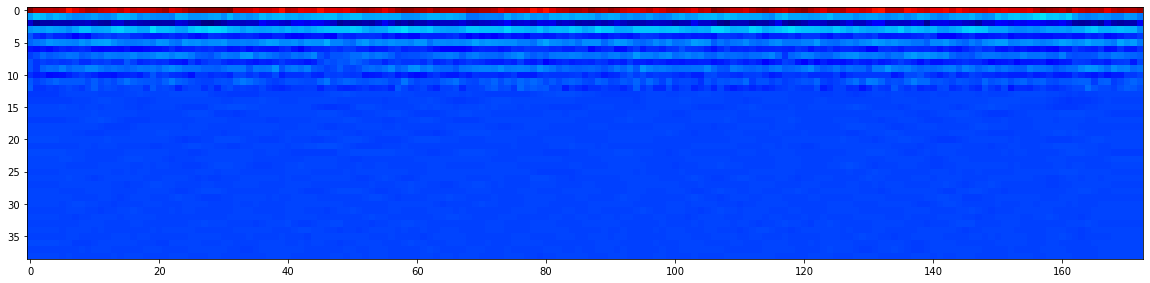

In [79]:
plt.figure(figsize=(20,5))
plt.imshow(comprehensive_mfccs, cmap='jet')
plt.show()

In [254]:
130/3

43.333333333333336

In [255]:
from scipy.signal import stft
window_size: int = 512
sr = 22050
bot_bins_out: int = 4
top_bins_out: int = 24
overlapping = .75

f, t, Zxx = stft(samples[:3*sr], nperseg=window_size, nfft=window_size, window='hann', noverlap=int(window_size * overlapping),
                     fs=sr)
Zxx = np.abs(Zxx)
Zxx = Zxx[bot_bins_out:-top_bins_out, :]
Zxx = np.log1p(Zxx)

(229, 518)


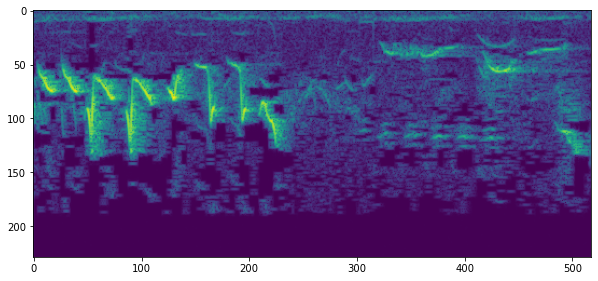

In [256]:
print(Zxx.shape)
plt.figure(figsize=(10,5))
plt.imshow(Zxx)
plt.show()

In [4]:
from pydub import AudioSegment
import matplotlib.pyplot as plt
from scipy.io import wavfile
from tempfile import mktemp

In [26]:
song = AudioSegment.from_mp3(r'./test/Turdus-philomelos-240109.mp3')

In [24]:
song = AudioSegment.from_mp3(r'./test/Turdus-philomelos-240109.mp3')
samples = np.array(song.get_array_of_samples(), dtype=float).reshape(-1, song.channels)
# .reshape(-1, track.channels)

# samples = song.get_array_of_samples()
# samples = np.array(samples, dtype=float)

# signal, _ = librosa.load(r'./test/Turdus-philomelos-240109.mp3', sr=22050)

WINDOW_SIZE = 512
y = librosa.stft(samples, hop_length=512, n_fft = WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:1000]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

ParameterError: Invalid shape for monophonic audio: ndim=2, shape=(2827055, 2)

In [3]:
data = pd.read_csv(r'metadata.csv')
data['Name'] = data.Genus +' '+ data.Specific_epithet

def timedeltas(x):
    t = datetime.strptime(x, '%M:%S').time()
    return timedelta(minutes=t.minute, seconds=t.second)

data['duration'] = data['Length'].apply(lambda x: timedeltas(x).total_seconds())

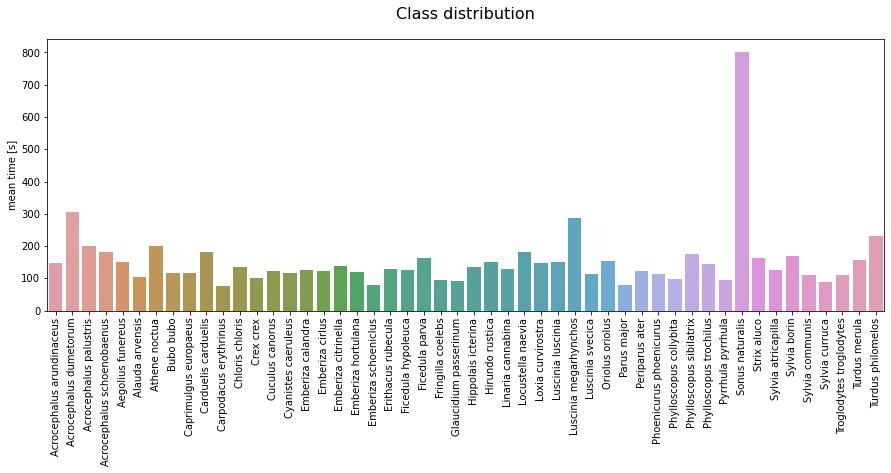

In [4]:
plotting = data.groupby(['Name'])['duration'].mean()
plt.figure(figsize=(15,5))
sns.barplot(x=plotting.index, y=plotting.values, saturation=0.6)
plt.xticks(rotation = 90)
plt.xlabel(None)
plt.ylabel('mean time [s]')
plt.title('Class distribution', fontdict={'size':16}, y=1.05)
plt.show()

In [29]:
# data[['sample_rate', 'num_samples']] = add_sample_info(data, 'Path', dur=False)

# with open('dataset.pkl', 'wb') as f:
#     pickle.dump(data, f)

with open('dataset.pkl', 'rb') as f:
    data = pickle.load(f)

classes = data.Name.unique()

signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes[0:4]:
    ix = data[data.Name == c].index[-1]
    f = data.loc[ix].Path
    fs = data.loc[ix].sample_rate
    signal, rate = librosa.load(f, sr=fs)
    signals[c] = signal
    fft[c] = fft_calc(signal, rate)

C:\Users\antos\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [30]:
sample_plot = ap.exploration.Visualize(signal=signals, fft=fft)

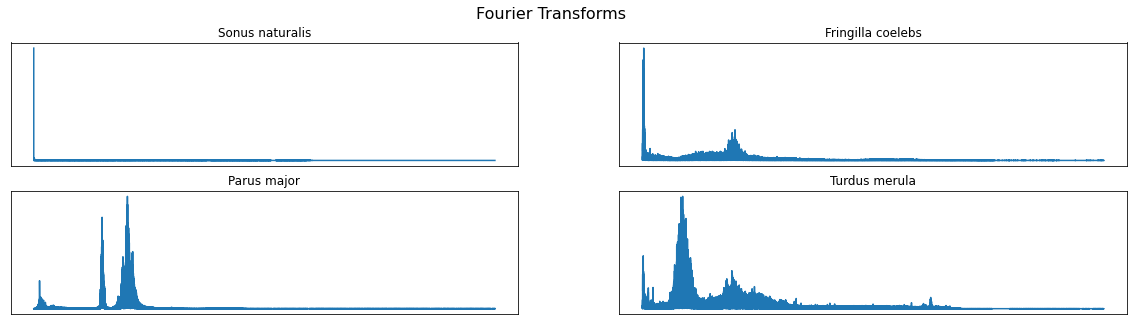

In [32]:
sample_plot.fft_plot()

In [241]:
from python_speech_features import mfcc, logfbank

In [249]:
# signals = {}
# fft = {}
# fbank = {}
# mfccs = {}

# for c in class_names:
#     mp3_file = data[data.Name == c].iloc[0,0]
#     song = AudioSegment.from_mp3(file)
#     fs = song.frame_rate
#     signal, _ = librosa.load(file, sr=fs)
#     signals[c] = signal
#     fft[c] = calc_fft(signal, fs)
    
#     bank = logfbank(signal[:fs], fs, nfilt=128, nfft=1200).T
#     fbank[c] = bank
#     mel = mfcc(signal[:fs], fs, numcep=64, nfilt=128, nfft=1200).T
#     mfccs[c] = mel

In [66]:
import os

In [46]:
from pydub import AudioSegment

In [61]:
song = AudioSegment.from_mp3(r'./Sonus-naturalis-156938.mp3')
samples = song.get_array_of_samples()
samples = np.array(samples, dtype=float)

In [62]:
samples = song.get_array_of_samples()

In [63]:
samples = np.array(samples, dtype=float)

C:\Users\antos\anaconda3\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


371 ms ± 6.92 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


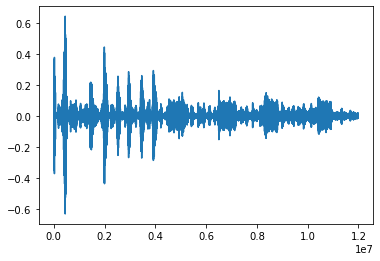

In [45]:
file = r'./Sonus-naturalis-156938.mp3'
song = AudioSegment.from_mp3(file)
fs = song.frame_rate

signal, _ = librosa.load(file, sr=fs)
plt.plot(signal)
plt.show()

In [259]:
import sox

In [260]:
cbn = sox.Transformer()
cbn.convert(samplerate=22050, n_channels=1)
cbn.build(
    input_filepath = './mp3/Sonus-naturalis-156938.mp3', output_filepath = 'Sonus-naturalis-156938.mp3'
)

True

In [261]:
import librosa.display

plt.figure(figsize=(14, 5))
librosa.display.waveplot(signal, sr=fs)
plt.show()

NameError: name 'signal' is not defined

<Figure size 1008x360 with 0 Axes>

In [92]:
# import IPython.display as ipd
# ipd.Audio(x, rate=fs)

(257, 500)


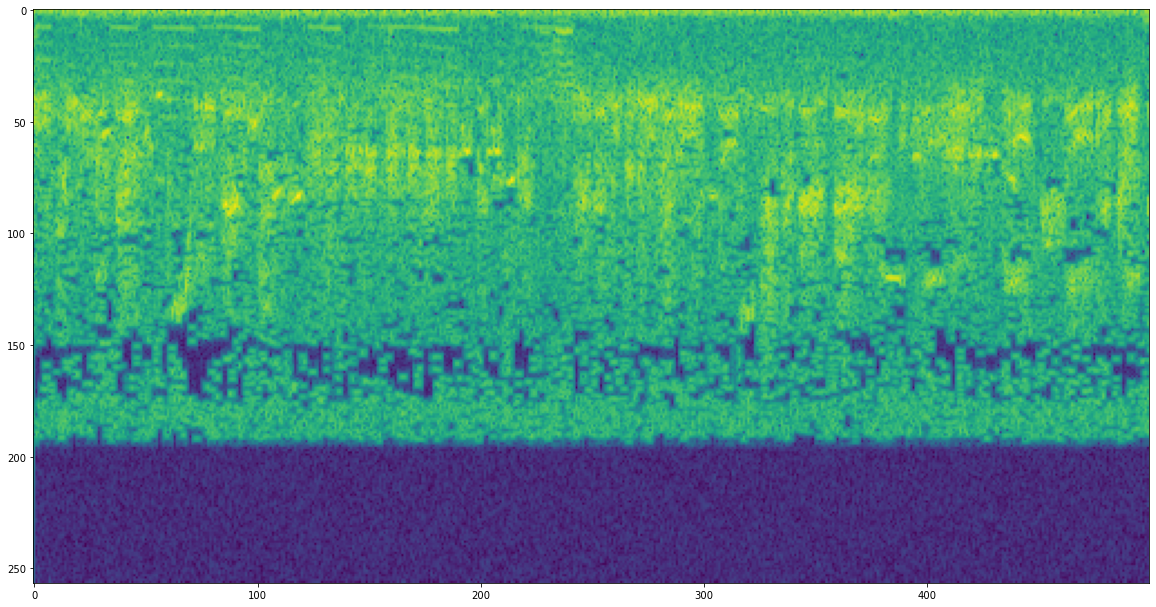

In [280]:
WINDOW_SIZE = 512
y = librosa.stft(samples, hop_length=256, n_fft = WINDOW_SIZE)#, hop_length = 512)
# y = librosa.feature.melspectrogram(x, sr=44100, n_fft=WINDOW_SIZE, hop_length=WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:500]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()

(257, 500)


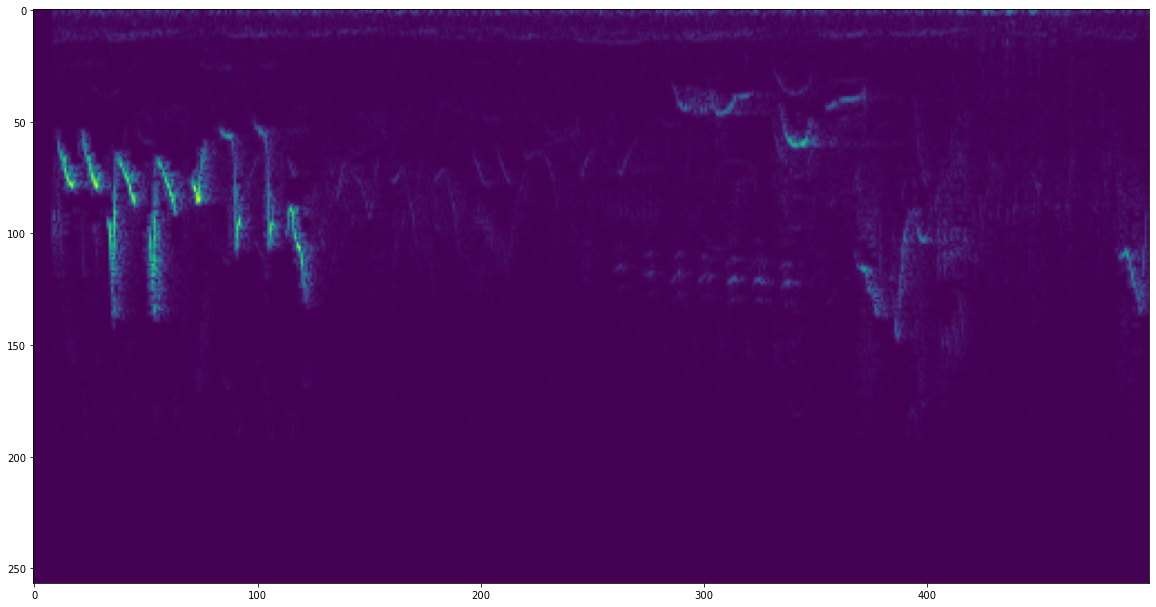

In [41]:
WINDOW_SIZE = 512
y = librosa.stft(signal, hop_length=256, n_fft = WINDOW_SIZE)#, hop_length = 512)
# y = librosa.feature.melspectrogram(x, sr=44100, n_fft=WINDOW_SIZE, hop_length=WINDOW_SIZE)

y = np.log1p(np.abs(y[:,:500]))
print(y.shape)

plt.figure(figsize=(20,20))
plt.imshow(y)
plt.show()